# Topic modeling for tags

1. Content aggregation: By scraping news headlines and tags from multiple sources, it is possible to create a news aggregation platform that provides a comprehensive overview of the latest stories on a variety of topics.

2. Sentiment analysis: By analyzing the sentiment of news headlines over time, it is possible to track changes in public opinion on various topics. This could be useful for businesses, governments, and other organizations that want to understand how their actions or policies are being received by the public.

3. Market research: By tracking the frequency and content of news articles related to specific industries or companies, it is possible to gain insights into market trends and the performance of individual firms.

4. Media monitoring: By tracking the publication of news articles related to a specific person, company, or topic, it is possible to monitor media coverage and respond to any negative or false information that may be published.

5. Data visualization: By visualizing the volume and content of news articles over time, it is possible to create graphical representations of trends and patterns in the news. This could be useful for journalists, researchers, or anyone interested in understanding how a particular topic has evolved over time.

How does a topic evolve over time?

In [1]:
import pandas as pd
from collections import Counter
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
sns.set_theme(style="ticks")
sns.set_palette("Paired")

from typing import List, Dict

In [2]:
# def flatten(l):
#     return [item for sublist in l for item in sublist]

In [3]:
# load cleaned dataset
df_news = pd.read_parquet("data/news/tagesschau/2022/tagesschau-news.parquet")
df_news['tags'] = df_news['tags'].apply(lambda x: x.split(','))

# What are the top tags?
df_top_n_tags_for_2022 = pd.read_parquet("data/news/tagesschau/2022/tagesschau-top-tags.parquet")

In [4]:
def find_cooccurring_tags(article_tags: List[List[str]], target_tag: str, duplicates: bool=True) -> List[str]:
    """
    Finds all tags and their frequency that co-occur with the target tag in a list of article tags. 

    Parameters
    ----------
    article_tags : List[List[str]]
        List of lists where each list contains tags of an article.
    target_tag : str
        The tag for which co-occurring tags need to be found.
    duplicates : bool, optional
        If False, return each co-occurring tag just once., by default True

    Returns
    -------
    List[str]
        A list of co-occurring tags.
    """    
    cooccurring_tags = []
    for tags in article_tags:
        if target_tag in tags:
            for tag in tags:
                if tag != target_tag:
                        cooccurring_tags.append(tag)
    if duplicates:
        return cooccurring_tags
    else:
        return list(set(cooccurring_tags))

def calculate_relative_counts(tags: List[str]) -> Dict[str, float]:
    """
    Given a list of tags, it returns a dictionary of relative frequency of each tag in the list.

    Parameters
    ----------
    tags : List[str]
        A list of tags whose relative frequency needs to be calculated.

    Returns
    -------
    Dict[str, float]
        A dictionary of relative frequency of each tag.
    """    
    tag_counter = Counter(tags)
    total_count = sum(tag_counter.values())
    relative_counts = {tag: count/total_count for tag, count in tag_counter.items()}
    return relative_counts


def calculate_absolute_counts(tags: List[str]) -> Dict[str, float]:
    """
    Given a list of tags, it returns a dictionary of absolute frequency of each tag in the list.

    Parameters
    ----------
    tags : List[str]
        A list of tags whose absolute frequency needs to be calculated.

    Returns
    -------
    Dict[str, float]
        A dictionary of absolute frequency of each tag.
    """
    absolute_counts = Counter(tags)
    return dict(absolute_counts)


def get_cooccurring_counts(article_tags: List[str], target_tag: str) -> pd.DataFrame:
    """
    Given a list of tags and a target tag, it returns a DataFrame containing the relative and absolute counts 
    of co-occurring tags and target tag.

    Parameters
    ----------
    article_tags : List[str]
        A list of tags whose co-occurring tags needs to be calculated.
    target_tag : str
        The target tag whose co-occurring tags need to be calculated

    Returns
    -------
    pd.DataFrame
        A DataFrame containing the relative and absolute counts of co-occurring tags and target tag.
    """
    cooccurring_tags = find_cooccurring_tags(article_tags, target_tag)
    df_cooccurring_tags = pd.DataFrame({
        'relative_count': calculate_relative_counts(cooccurring_tags),
        'absolute_count': calculate_absolute_counts(cooccurring_tags)
        }).reset_index().rename(columns={'index': 'cooccurring_tag'})
    df_cooccurring_tags['tag'] = target_tag
    return df_cooccurring_tags.sort_values('absolute_count', ascending=False).reset_index(drop=True)

def get_cooccurring_tag_counts_matrix(article_tags: List[str], target_tags: List[str]) -> pd.DataFrame:
    cooccurring_tag_counts_matrix = pd.DataFrame()
    for target_tag in target_tags:
        cooccurring_tag_counts = get_cooccurring_counts(article_tags, target_tag)
        cooccurring_tag_counts_matrix = pd.concat([cooccurring_tag_counts_matrix, cooccurring_tag_counts], axis=0)
    return cooccurring_tag_counts_matrix

def test_cooccurring_tag_counts_matrix():
    article_tags = [
        ["Papst Benedikt XVI.", "Vatikan", "Papst"],
        ["Ukraine", "Angriffe", "Russland", "Kiew"],
        ["Ukraine", "Russland"]
    ]
    target_tags = ["Russland", "Papst"]
    cooccurring_tag_counts_matrix = get_cooccurring_tag_counts_matrix(article_tags, target_tags)
    return cooccurring_tag_counts_matrix

In [5]:
cooccurring_tag_counts_matrix = get_cooccurring_tag_counts_matrix(article_tags=df_news['tags'], target_tags=df_top_n_tags_for_2022['tag'])

In [6]:
cooccurring_tag_counts_matrix.query("relative_count > 0.01")

,cooccurring_tag,relative_count,absolute_count,tag
0,Russland,0.146382,967,Ukraine
1,Liveblog,0.046019,304,Ukraine
2,Krieg,0.040418,267,Ukraine
3,Ukraine-Krieg,0.034514,228,Ukraine
4,Mariupol,0.018317,121,Ukraine
...,...,...,...,...
9,Aktien,0.015697,24,Börse
10,Kurssturz,0.014388,22,Börse
11,Tesla,0.013734,21,Börse
12,Geldanlage,0.013734,21,Börse


<AxesSubplot:xlabel='absolute_count', ylabel='cooccurring_tag'>

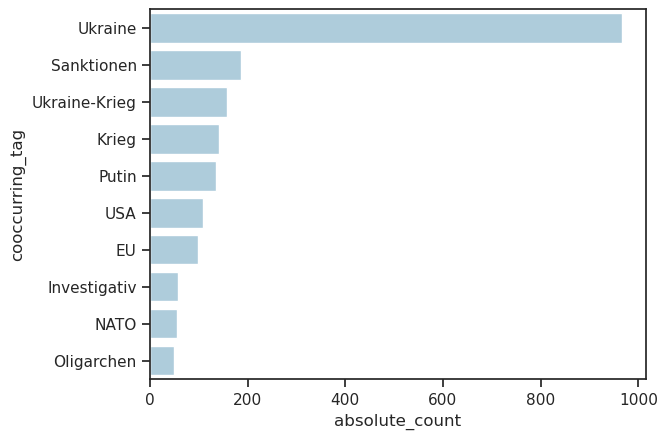

In [7]:
fig, ax = plt.subplots()
sns.barplot(data=cooccurring_tag_counts_matrix.query("(relative_count > 0.01) & (tag == 'Russland')"), y='cooccurring_tag', x='absolute_count', color='C0')

## Analyze the intersection between topics based on the related tags

Let's assume that the topics are represented by the most frequently used tags throughout the year. Following this idea, *Ukraine*, *Russland* or *Coronavirus* are examples for topics in the last year. While *Coronavirus* and *Ukraine* can be most likely treated as independent topics, *Russland* and *Ukraine*, on the other hand, are strongly correlated. The topic quality can be increased by merging correlating topics, such that ultimately only topics remain that differentiate strongly from one another. 
For this reason, a metric that quantifies the overlap between topic pairs is necessary. For the first attempt, the overlap between two sets of co-occurring tags corresponding to a topic pair can be utilized as a similarity measure. 

In [8]:
topics = df_top_n_tags_for_2022['tag']
print(topics)

0           Ukraine
1          Russland
2       Coronavirus
3               USA
4      Energiekrise
5                EU
6     Ukraine-Krieg
7             China
8          Liveblog
9         Inflation
10     Investigativ
11            Krieg
12              DAX
13           Scholz
14            Börse
Name: tag, dtype: object


There are several ways to create all pairs from a list in Python, depending on the desired output format and level of complexity. Here we are using the module itertools

In [9]:

topic_pairs = list(itertools.combinations(topics, 2))
print(topic_pairs[:3])


[('Ukraine', 'Russland'), ('Ukraine', 'Coronavirus'), ('Ukraine', 'USA')]


In [10]:
from typing import Literal, Union

The Jaccard similarity, the overlap coefficient, and the Dice coefficient are all measures of similarity between two sets. However, they are defined slightly differently, and thus have different properties.

Jaccard similarity: This is defined as the size of the intersection of two sets divided by the size of the union of the two sets. It ranges from 0 to 1, with a value of 1 indicating that the two sets are identical and a value of 0 indicating that they have no elements in common. Jaccard similarity is sensitive to the relative size of the two sets, and it tends to favor smaller sets.

Overlap coefficient: This is defined as the size of the intersection of two sets divided by the smaller of the two set sizes. It ranges from 0 to 1, with a value of 1 indicating that the two sets are identical and a value of 0 indicating that they have no elements in common. The overlap coefficient is less sensitive to the relative size of the two sets than Jaccard similarity.

Dice coefficient: This is defined as twice the size of the intersection of two sets divided by the sum of the sizes of the two sets. It ranges from 0 to 1, with a value of 1 indicating that the two sets are identical and a value of 0 indicating that they have no elements in common. Dice coefficient is similar to the overlap coefficient, but it tends to be slightly more sensitive to the relative size of the two sets than the overlap coefficient.

In general, Jaccard similarity, Overlap coefficient, and Dice coefficient all gives the same results but they are sensitive to the different situations. Jaccard similarity is best used when both sets are of similar size and you want to give equal weight to the presence and absence of elements. Overlap coefficient is best used when both sets are of different size and you want to give more weight to the presence of elements. Dice coefficient is best used when both sets are of similar size and you want to give more weight to the presence of elements.

In [43]:
def get_similarity_score(set1: set, set2: set, method: Literal["jaccard", "overlap", "dice"]="jaccard") -> Dict[str, Union[float,str,List[str]]]:
    """
    Calculates the similarity score of two sets according to a specified method.

    Parameters
    ----------
    set1 : set
        The first set.
    set2 : set
        The second set.
    method : {'jaccard', 'dice', 'overlap'}
        The method to use for calculating the similarity score. 
        
    Returns
    -------
    float
        The similarity score (between 0 and 1)
        
    Raises
    ------
    ValueError
        If the method specified is not 'jaccard', 'dice' or 'overlap'
    TypeError
        If the input sets are not of type set
        
    Examples
    --------
    >>> similarity_score({1, 2, 3}, {2, 3, 4}, 'jaccard')
    0.5
    >>> similarity_score({1, 2, 3}, {2, 3, 4}, 'dice')
    0.6666666666666666
    >>> similarity_score({1, 2, 3}, {2, 3, 4}, 'overlap')
    0.6666666666666666
    """
    if method == "jaccard":
        score = len(set1.intersection(set2)) / len(set1.union(set2))
    elif method == "overlap":
        score = len(set1.intersection(set2)) / min(len(set1), len(set2))
    elif method == "dice":
        score = 2 * len(set1.intersection(set2)) / (len(set1) + len(set2))
    else:
        raise ValueError(f"Method {method} not known.")
    return score

def get_similarity_for_topic_pair(topic_pair: tuple, threshold_relative_count: float=0.005, method: Literal["jaccard", "overlap", "dice"]="jaccard"):
    """
    Evaluates the similarity of a topic pair according to a specified similarity score function.
    
    Parameters
    ----------
    topic_pair : tuple
        Topic pair represented as tuple of strings.
    # score_func : function, optional
    #     The similarity score function to use for evaluating the similarity between the topics.
    #     If None, Jaccard Similarity will be used as default.
        
    # Returns
    # -------
    # float
    #     The similarity score (between 0 and 1)
        
    # Raises
    # ------
    # TypeError
    #     If the input topics are not of type list
    # ValueError
    #     If the score_func is not callable or None
   
    # Examples
    # --------
    # topic_similarity(["machine", "learning", "AI"], ["Deep", "learning", "AI"])
    # topic_similarity(["machine", "learning", "AI"], ["Deep", "learning", "AI"], score_func = cosine_similarity)
    """
    def get_mask(threshold_relative_count, topic):
        mask = (cooccurring_tag_counts_matrix['relative_count'] > threshold_relative_count) & (cooccurring_tag_counts_matrix['tag'] == topic)
        if mask.any():
            return mask
        else:
            raise ValueError(f"The conditions threshold_relative_count={threshold_relative_count} and topic={topic} would return an empty dataframe")
    
    set1, set2 = [set(cooccurring_tag_counts_matrix.loc[get_mask(threshold_relative_count, topic), 'cooccurring_tag']) for topic in topic_pair]
    tag_intersection = list(set1.intersection(set2))
    similarity_score = get_similarity_score(set1,set2, method=method)
    return {'topic_pair': topic_pair, 'tags': tag_intersection, 'similarity': similarity_score, 'method': method}

In [35]:
similarity_methods = ['jaccard', 'overlap', 'dice']
topic_pair_similarity = pd.DataFrame()
for method in similarity_methods:
    for topic_pair in topic_pairs:
        similarity_for_topic_pair = get_similarity_for_topic_pair(topic_pair, method=method, threshold_relative_count=0.005)
        new_row = pd.DataFrame({key: [value] for key, value in similarity_for_topic_pair.items()})
        topic_pair_similarity = pd.concat([topic_pair_similarity, new_row])
topic_pair_similarity.reset_index(drop=True, inplace=True)



### Evaluate the similarity measure

In [36]:
topic_pair_similarity

,topic_pair,tags,similarity,method
0,"(Ukraine, Russland)","[Scholz, Mariupol, Energiekrise, NATO, USA, EU...",0.424242,jaccard
1,"(Ukraine, Coronavirus)","[Liveblog, USA]",0.037736,jaccard
2,"(Ukraine, USA)","[Russland, NATO, Biden, EU, Sanktionen]",0.121951,jaccard
3,"(Ukraine, Energiekrise)","[Sanktionen, EU, Scholz, Russland]",0.068966,jaccard
4,"(Ukraine, EU)","[Scholz, Russland, Energiekrise, NATO, USA, Sa...",0.209302,jaccard
...,...,...,...,...
310,"(Krieg, Scholz)","[Russland, Deutschland, EU, Ukraine, Putin, Kiew]",0.210526,dice
311,"(Krieg, Börse)","[Ukraine, Russland]",0.081633,dice
312,"(DAX, Scholz)","[Inflation, Ukraine, China, Russland]",0.115942,dice
313,"(DAX, Börse)","[Leitzins, Russland, Gold, Zinsen, Goldpreis, ...",0.918033,dice


<AxesSubplot:xlabel='similarity', ylabel='Count'>

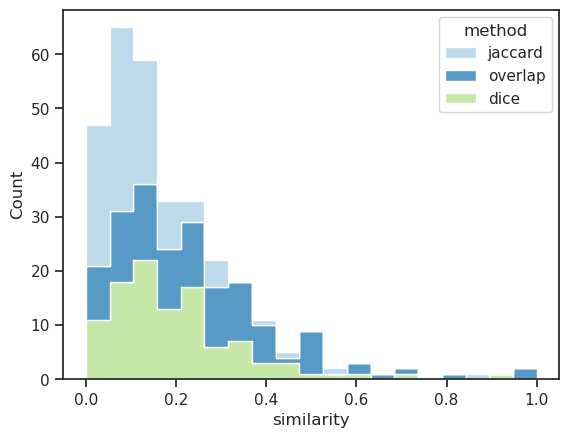

In [37]:
fig, ax = plt.subplots()
sns.histplot(data=topic_pair_similarity, x='similarity', hue='method', element='step', multiple='stack', cumulative=False)

In [44]:
similar_topic_pairs = topic_pair_similarity.sort_values(['method','similarity'], ascending=[True, False]).groupby('method').head(10)
topic_pairs_by_method = {method: set(similar_topic_pairs.loc[similar_topic_pairs['method'] == method, 'topic_pair']) for method in similarity_methods}
for method_pair in itertools.combinations(similarity_methods, 2):
    score = get_similarity_score(topic_pairs_by_method[method_pair[0]], topic_pairs_by_method[method_pair[1]])
    print(f"Method pair: {method_pair}, Score: {score}")
    

Method pair: ('jaccard', 'overlap'), Score: 0.42857142857142855
Method pair: ('jaccard', 'dice'), Score: 1.0
Method pair: ('overlap', 'dice'), Score: 0.42857142857142855


In [45]:
similar_topic_pairs

,topic_pair,tags,similarity,method
313,"(DAX, Börse)","[Leitzins, Russland, Gold, Zinsen, Goldpreis, ...",0.918033,dice
215,"(Ukraine, Ukraine-Krieg)","[Cherson, Liveblog, Scholz, Charkiw, Biden, Ru...",0.695652,dice
210,"(Ukraine, Russland)","[Scholz, Mariupol, Energiekrise, NATO, USA, EU...",0.595745,dice
228,"(Russland, Ukraine-Krieg)","[Scholz, Deutschland, NATO, USA, EU, China, Sa...",0.577778,dice
283,"(Ukraine-Krieg, Krieg)","[Cherson, Charkiw, Russland, Deutschland, EU, ...",0.476190,dice
220,"(Ukraine, Krieg)","[Cherson, Charkiw, Mariupol, Russland, EU, San...",0.454545,dice
270,"(EU, Ukraine-Krieg)","[Scholz, Russland, Deutschland, NATO, USA, Chi...",0.440000,dice
227,"(Russland, EU)","[Scholz, Energiekrise, Deutschland, NATO, USA,...",0.431373,dice
233,"(Russland, Krieg)","[Mariupol, Deutschland, EU, Sanktionen, Selens...",0.418605,dice
285,"(Ukraine-Krieg, Scholz)","[Biden, Deutschland, Russland, NATO, USA, EU, ...",0.372881,dice


Let's go with the *overlap* method 

In [46]:
pairs = similar_topic_pairs.query("method == 'overlap'")['topic_pair'].apply(lambda x: set(x)).tolist()

In [47]:
print(pairs)

[{'Liveblog', 'China'}, {'Börse', 'DAX'}, {'Investigativ', 'Liveblog'}, {'Ukraine-Krieg', 'Ukraine'}, {'Liveblog', 'Scholz'}, {'Ukraine', 'Russland'}, {'Ukraine-Krieg', 'Russland'}, {'Ukraine', 'Krieg'}, {'Liveblog', 'USA'}, {'Ukraine-Krieg', 'EU'}]


In [ ]:
# How to combine list of sets in python with the result that only sets remain that do not have intersections?

Note that this example uses the & operator to check if there is any intersection between the current set from the input list and the sets in the output list. If there is an intersection, that means that the current set shares at least one element with a set in the output list, so it can be unioned with that set.

In [48]:
def union_sets(input_sets: List[set]) -> List[set]:
    """
    This function takes a list of sets as input, and returns a new list of sets that contains the union of all sets that have at least one common element.
    
    Parameters
    ----------
    input_sets (list of sets): List of sets where each set contains elements.
    
    Returns
    ----------
    list of sets: List of sets that contains the union of all sets that have at least one common element.
    
    Example:
    ----------
    >>> input_sets = [{'a','b'}, {'a','c'}, {'d','e'}, {'f','g'}, {'a','f'}]
    >>> union_sets(input_sets)
    [{'a', 'b', 'c', 'f'}, {'d', 'e'}, {'f', 'g'}]
    """
    output = []
    for i in range(len(input_sets)):
        set_exists = False
        for j in range(len(output)):
            if output[j].intersection(input_sets[i]):
                output[j] = output[j].union(input_sets[i])
                set_exists = True
                break
        if not set_exists:
            output.append(input_sets[i])
    return output


In [50]:
from functools import reduce

In [51]:
aggregated_topic_sets = union_sets(pairs)
tags_in_aggregated_topics = reduce(set.union, union_sets(aggregated_topic_sets))
aggregated_topics = {','.join(list(item)) for item in union_sets(pairs)}
independent_topics = set(topics).difference(tags_in_aggregated_topics)
topics = independent_topics.union(aggregated_topics)

In [52]:
topics

{'Börse,DAX',
 'Coronavirus',
 'Energiekrise',
 'Inflation',
 'Investigativ,Liveblog,Scholz,USA,China',
 'Ukraine,EU,Russland,Ukraine-Krieg,Krieg'}

In [53]:
replace_dict = {}
for replace_by in aggregated_topics:
    replace_dict.update({to_replace: replace_by for to_replace in replace_by.split(',')})


In [54]:
print(replace_dict)

{'Börse': 'Börse,DAX', 'DAX': 'Börse,DAX', 'Ukraine': 'Ukraine,EU,Russland,Ukraine-Krieg,Krieg', 'EU': 'Ukraine,EU,Russland,Ukraine-Krieg,Krieg', 'Russland': 'Ukraine,EU,Russland,Ukraine-Krieg,Krieg', 'Ukraine-Krieg': 'Ukraine,EU,Russland,Ukraine-Krieg,Krieg', 'Krieg': 'Ukraine,EU,Russland,Ukraine-Krieg,Krieg', 'Investigativ': 'Investigativ,Liveblog,Scholz,USA,China', 'Liveblog': 'Investigativ,Liveblog,Scholz,USA,China', 'Scholz': 'Investigativ,Liveblog,Scholz,USA,China', 'USA': 'Investigativ,Liveblog,Scholz,USA,China', 'China': 'Investigativ,Liveblog,Scholz,USA,China'}


In [55]:
cooccurring_tag_counts_matrix['tag'] = cooccurring_tag_counts_matrix['tag'].replace(replace_dict)

Clustering tags to topics, e.g. DAX,Börse, leads to the fact that we need to regroup the count statistics. 

In [56]:
cooccurring_agg_tag_counts_matrix = cooccurring_tag_counts_matrix.groupby(['tag','cooccurring_tag']).agg({'absolute_count': 'sum'}).reset_index()
cooccurring_agg_tag_counts_matrix['relative_count'] = cooccurring_agg_tag_counts_matrix.groupby('tag')['absolute_count'].transform(lambda x: x / x.sum())
cooccurring_agg_tag_counts_matrix = cooccurring_agg_tag_counts_matrix.sort_values(['tag', 'absolute_count'], ascending=[True, False]).reset_index(drop=True)

In [61]:
# topics
cooccurring_agg_tag_counts_matrix['tag'].unique()

array(['Börse,DAX', 'Coronavirus', 'Energiekrise', 'Inflation',
       'Investigativ,Liveblog,Scholz,USA,China',
       'Ukraine,EU,Russland,Ukraine-Krieg,Krieg'], dtype=object)

In [63]:
cooccurring_agg_tag_counts_matrix[cooccurring_agg_tag_counts_matrix['tag'] == 'Ukraine,EU,Russland,Ukraine-Krieg,Krieg'].head(20)

,tag,cooccurring_tag,absolute_count,relative_count
3599,"Ukraine,EU,Russland,Ukraine-Krieg,Krieg",Ukraine,1581,0.105548
3600,"Ukraine,EU,Russland,Ukraine-Krieg,Krieg",Russland,1365,0.091128
3601,"Ukraine,EU,Russland,Ukraine-Krieg,Krieg",Krieg,417,0.027839
3602,"Ukraine,EU,Russland,Ukraine-Krieg,Krieg",Ukraine-Krieg,409,0.027305
3603,"Ukraine,EU,Russland,Ukraine-Krieg,Krieg",Liveblog,337,0.022498
3604,"Ukraine,EU,Russland,Ukraine-Krieg,Krieg",Sanktionen,330,0.022031
3605,"Ukraine,EU,Russland,Ukraine-Krieg,Krieg",Putin,304,0.020295
3606,"Ukraine,EU,Russland,Ukraine-Krieg,Krieg",USA,245,0.016356
3607,"Ukraine,EU,Russland,Ukraine-Krieg,Krieg",EU,242,0.016156
3608,"Ukraine,EU,Russland,Ukraine-Krieg,Krieg",Selenskyj,205,0.013686


you can ask ChatGPT for generating a text containing those keywords

# Evolution of tags
Create a slope graph to show the evolution of tag occurrence between the current and previous month.

In [70]:
import pickle
import numpy as np
from datetime import date

In [65]:
with open('data/news/tagesschau/2022/summed_tags.pkl', 'rb') as handle:
    summed_tags = pickle.load(handle)


In [67]:
mask = summed_tags['monthly'].index.month == 5
tag_counts_5 = summed_tags['monthly'].loc[mask, 'tags_frequency'].item()

mask = summed_tags['monthly'].index.month == 6
tag_counts_6 = summed_tags['monthly'].loc[mask, 'tags_frequency'].item()

mask = summed_tags['monthly'].index.month == 7
tag_counts_7 = summed_tags['monthly'].loc[mask, 'tags_frequency'].item()

mask = summed_tags['monthly'].index.month == 8
tag_counts_8 = summed_tags['monthly'].loc[mask, 'tags_frequency'].item()

In [68]:
df = pd.DataFrame(tag_counts_8.most_common(4), columns=['tag', 'counts_8']).set_index('tag')

In [69]:
df['counts_5'] = 0
df['counts_6'] = 0
df['counts_7'] = 0

for tag in df.index:
    df.loc[tag, 'counts_5'] = tag_counts_5[tag]
    df.loc[tag, 'counts_6'] = tag_counts_6[tag]
    df.loc[tag, 'counts_7'] = tag_counts_7[tag]
    

## Slope graph

In [71]:
# # Define the x and y values for the slope
# x = [date(2021,1,1), date(2022,1,1)]
# y = [np.random.randint(1,10, size=len(x)) for _ in range(4)]
# index = x
# labels = [f"Label {i}" for i in range(4)]
# values = y
# df = pd.DataFrame(data={label: value for label, value in zip(labels, values)}, index=index)

In [72]:
def plot_slope_graph(x, y, labels, xticks=None):
    # Create the plot
    if xticks is None:
        xticks = x
    labels_coords = []
    label_counter = {key: 0 for key in [y_[0] for y_ in y]}
    y_offset = 0
    num_digits = len(str(np.max([y_[0] for y_ in y])))
    x_offset = -25 - (5 * num_digits)
    fig, ax = plt.subplots(figsize=(6,8), tight_layout=True)
    for i, y_ in enumerate(y):
        if y_[1] > y_[0]:
            color = 'C0'
            weight = 'bold'
        else:
            color = 'grey'
            weight = 'normal'
        ax.plot(x, y_, color=color, linewidth=3)
        ax.scatter([x[0],x[-1]], [y_[0],y_[-1]], c=color, marker='o', s=100)
        ax.annotate(f"{y_[0]}", xy=(x[0],y_[0]), xytext=(-10,0), textcoords='offset points', horizontalalignment='right', verticalalignment='center', color=color, weight=weight)
        ax.annotate(f"{y_[-1]}", xy=(x[-1],y_[-1]), xytext=(10,0), textcoords='offset points', horizontalalignment='left', verticalalignment='center', color=color, weight=weight)
        
        
        label_coords = (x[0],y_[0])
        label_y_offset = y_offset
        if label_coords in labels_coords:
            label_counter[y_[0]] +=1
            y_offset = 15 * label_counter[y_[0]]
        else:
            y_offset = 0
        ax.annotate(labels[i], xy=label_coords, xytext=(x_offset,0-y_offset), textcoords='offset points', horizontalalignment='right', verticalalignment='center', color=color)
        labels_coords.append((x[0],y_[0]))
        # labels['y_offset'].append(y_offset)
    # if x_label is not None:
    #     ymax = np.max([y_[0] for y_ in y])
    #     ax.annotate(x_label, xy=(x[0],ymax), xytext=(x_offset,30), textcoords='offset points', horizontalalignment='right', verticalalignment='center', color=color)
    #     ax.annotate("|", xy=(x[0],ymax), xytext=(x_offset+5,30), textcoords='offset points', horizontalalignment='center', verticalalignment='center', color=color)
    # if y_label is not None:
    #     ymax = np.max([y_[0] for y_ in y])
    #     ax.annotate(y_label, xy=(x[0],ymax), xytext=(-10,30), textcoords='offset points', horizontalalignment='right', verticalalignment='center', color=color)
    # plt.xticks(x, xticks)
    # remove the y-axis
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    # plt.gca().spines['top'].set_visible(False)

    # remove the y-axis
    ax.yaxis.set_visible(False)
    return fig, ax


In [73]:
import calendar

In [74]:
y = df[['counts_5', 'counts_6','counts_7','counts_8']].values
x = [calendar.month_abbr[month_num] for month_num in [5,6,7,8]]
labels = df.index

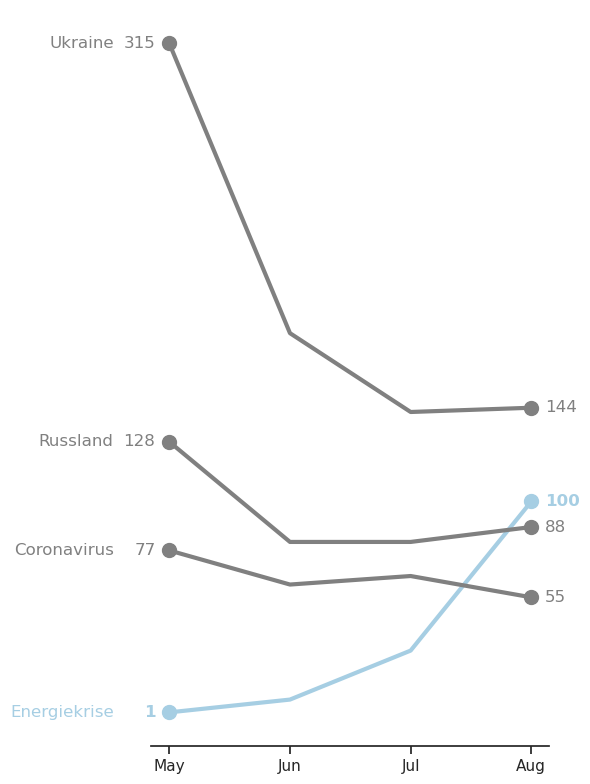

In [75]:
fig, ax = plot_slope_graph(x,y,labels)

In [77]:
fig.savefig("data/news/tagesschau/2022/sample-tag-evolution.png", dpi=300, )